[리조트 호텔 취소 예측 분류 모델 만들기]
- 타겟 : is_canceled
- 피처 : is_canceled와의 상관계수가 0.10 이상인 모든 컬럼.
- 모델 : 분류

In [108]:
# 모듈 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 데이터 불러오기
file = '../data/hotel_bookings.csv'
htDF = pd.read_csv(file)

In [109]:
#htDF['booking_changes'].unique()

데이터 전처리<hr>

In [110]:
# 호텔의 값 중에 Resort Hotel만 분리.
rtDF = htDF[htDF['hotel']=='Resort Hotel']
rtDF.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

<컬럼 정보>
- hotel : 예약한 호텔의 종류 (예: Resort Hotel, City Hotel) = 결측치 없음. (City Hotel 66% Resort Hotel 34%)

- is_canceled : 예약이 취소되었는지 여부 (1: 취소, 0: 취소되지 않음) = 결측치 없음(Mean 0.37,  Std. Deviation 0.48)

- lead_time : 예약이 이루어진 날짜와 체크인 날짜 간의 기간 (일) = 결측치 없음(Mean104 Std. Deviation 107)

- 도착년도 arrival_date_year : 도착한 연도 = (Mean 2.02k,    Std. Deviation 0.71)

- 도착 월 arrival_date_month : 도착한 월 = August 12%   July 11% Other (92852) 78%

- 도착 주 (ex - 27주차) arrival_date_week_number : 도착한 주 (연중 주 단위) = (Mean 27.2   Std. Deviation 13.6 )

- 도착 일 arrival_date_day_of_month : 도착한 날짜 = (Mean 15.8   Std. Deviation 8.78) = (+ 도착년도+ 월+ 일 다 붙여서(아마 str로 변경해서) 날짜 데이터로 변경 가능할듯.)

- 주말 숙박 stays_in_weekend_nights : 주말에 머무른 밤 수 = (Mean 0.93    Std. Deviation 1)

- 평일 숙박 stays_in_week_nights : 주중에 머무른 밤 수 = (Mean 2.5  Std. Deviation 1.91)

- 성인 adults : Number of adults = (Mean 1.86 Std. Deviation 0.58)

- 아이 children : Number of children = Mismatched 4 (Mean0.1     Std. Deviation0.4)

- 아기 babies : Number of babies =(Mean 0.01  Std. Deviation 0.1)

- 예약한 식사 meal : Type of meal booked. Categories are presented in standard hospitality meal packages: ===> 수치 데이터로 변경.
- 식사 예약 안함 = Undefined/SC – no meal package; 
- 숙박과 아침식사 = BB – Bed & Breakfast; 
- 아침식사와 그외 식사한끼(보통 저녁)HB – Half board (breakfast and one other meal – usually dinner); 
- 아침+점심+저녁 = FB – Full board (breakfast, lunch and dinner)
- (Unique 5)

- 출신국가 country : Country of origin. Categories are represented in the ISO 3155–3:2013 format (Unique 178)

- 시장 부문 market_segment : Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”
+ TA : Travel Agents= a person whose job is to help people who want to travel by buying plane tickets, making hotel reservations, etc.
+ TO : 여행사? Tour Operators = a company that makes arrangements for travel and places to stay

- 유통 경로 distribution_channel : Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”
+ TA : Travel Agents
+ TO : Tour Operators

- is_repeated_guest 이전에 방문한 적 있는 고객 : Value indicating if the booking name was from a repeated guest (1) or not (0)

- 이전 예약 취소 건수 previous_cancellations : 고객이 현재 예약 전에 취소한 이전 예약 수 Number of previous bookings that were cancelled by the customer prior to the current booking
- (Mean 0.09   Std. Deviation 0.84)

- 이전 예약이 취소되지 않았음. previous_bookings_not_canceled : 고객이 현재 예약 전에 이전 예약을 취소하지 않았음. Number of previous bookings not cancelled by the customer prior to the current booking
- (Mean 0.14   Std. Deviation 1.5)

- 예약된 객실 유형 reserved_room_type : Code of room type reserved. : (익명성을 이유로 코드로 제시.) Code is presented instead of designation for anonymity reasons.

- 제공된 방 유형 assigned_room_type : Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons.
	- 예약에 할당된 객실 유형

- 예약 변경 booking_changes : Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation
- (+PMS : Project management system)

- deposit_type : Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories: No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost; Refundable – a deposit was made with a value under the total cost of stay.
- 보증금 유형 : 보증금 없음 - 환불 불가 - 환불 가능

- agent : ID of the travel agency that made the booking
- 에이전트 : 예약한 여행사 아이디
- (=> Null 값이 14% )

- company : ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons
	예약을 한 업체/단체 아이디. 익명성을 이유로 아이디 제시. => 결측치가 너무 많아서 삭제.
- (=> Null 값이 94%기 때문에 )

- days_in_waiting_list : Number of days the booking was in the waiting list before it was confirmed to the customer
- 대기일수 : 예약이 고객에게 확인되기 전 일수 

- customer_type : Type of booking, assuming one of four categories: Contract - when the booking has an allotment or other type of contract associated to it; Group – when the booking is associated to a group; Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-party – when the booking is transient, but is associated to at least other transient booking
- 고객 유형 : 

- adr : Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights
	: 일평균 숙박요금(숙박비의 총합을 숙박일수로 나눈 값)

- required_car_parking_spaces : Number of car parking spaces required by the customer
- 주차장 공간 : 고객이 필요한 주차장 공간

- total_of_special_requests : Number of special requests made by the customer (e.g. twin bed or high floor)
	- 총 추가 요청사항 개수 : 투숙객 추가 요청사항 

- reservation_status : Reservation last status, assuming one of three categories: 
- Canceled – booking was canceled by the customer; 
- Check-Out – customer has checked in but already departed;
- No-Show – customer did not check-in and did inform the hotel of the reason why
- 예약 현황 : 취소 / 체크아웃/ no show

- reservation_status_date : Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking - - - canceled or when did the customer checked-out of the hotel
- 예약 현황 날짜 : 마지막 상태를 설정한 날짜. 예약 현황과 함께 취소일 혹은 체크아웃 날짜를 파악할 수 있음.

In [111]:
rtDF['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [112]:
# 월 데이터 형 변환.
rtDF['arrival_date_month'] = rtDF['arrival_date_month'].replace({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,
                                                                  'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}).astype(int)

C:\Users\KDP-48\AppData\Local\Temp\ipykernel_17252\3131013796.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rtDF['arrival_date_month'] = rtDF['arrival_date_month'].replace({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,


In [113]:
#rtDF['arrival_date_month'].info()
rtDF['deposit_type'].unique()

array(['No Deposit', 'Refundable', 'Non Refund'], dtype=object)

In [114]:
# 보증금 No Deposit => 0, refundable => 1, Non Refund => 2
rtDF['deposit_type'].unique()
rtDF['deposit_type'] = rtDF['deposit_type'].replace({'No Deposit':0, 'Refundable':1, 'Non Refund':2})
#rtDF['deposit_type'].info()

C:\Users\KDP-48\AppData\Local\Temp\ipykernel_17252\2325286407.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rtDF['deposit_type'] = rtDF['deposit_type'].replace({'No Deposit':0, 'Refundable':1, 'Non Refund':2})


In [115]:
# 예약 상태의 값 중 Check-Out을 0, Canceled/No-show을 1로 변경.
#rtDF['reservation_status'].unique()
rtDF['reservation_status'] = rtDF['reservation_status'].replace({'Check-Out':0, 'Canceled':1, 'No-Show':1})

C:\Users\KDP-48\AppData\Local\Temp\ipykernel_17252\3267963912.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rtDF['reservation_status'] = rtDF['reservation_status'].replace({'Check-Out':0, 'Canceled':1, 'No-Show':1})


In [116]:
#rtDF['assigned_room_type'].unique()

In [117]:
#A-E로 구성된 assigned_room_type을 수치데이터로 변경.

len(rtDF['assigned_room_type'].unique())

from sklearn.preprocessing import LabelEncoder
lblEncoder = LabelEncoder()

lblEncoder.fit(rtDF['assigned_room_type'])
rtDF['assigned_room_type'] = lblEncoder.transform(rtDF['assigned_room_type'])

lblEncoder.fit(rtDF['reserved_room_type'])
rtDF['reserved_room_type'] = lblEncoder.transform(rtDF['reserved_room_type'])

print(rtDF['assigned_room_type'].unique(), rtDF['reserved_room_type'].unique())

[ 2  0  3  4  6  5  8  1  7 10  9] [2 0 3 4 6 5 7 8 9 1]


C:\Users\KDP-48\AppData\Local\Temp\ipykernel_17252\3763201844.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rtDF['assigned_room_type'] = lblEncoder.transform(rtDF['assigned_room_type'])
C:\Users\KDP-48\AppData\Local\Temp\ipykernel_17252\3763201844.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rtDF['reserved_room_type'] = lblEncoder.transform(rtDF['reserved_room_type'])


In [118]:
rtcorr = abs(rtDF.corr(numeric_only=True))
rtcorr['is_canceled'].sort_values(ascending=False)

# => is canceled를 기준으로 상관계수를 도출해 보았더니 reservation_status 컬럼과 is_canceled가 완전히 같아져서 reservation status를 삭제하기로 결정.
# => 또한 결측값이 많은 company 컬럼을 삭제.

rtDF = rtDF.drop('reservation_status', axis=1)
rtDF = rtDF.drop('company', axis=1)
rtDF = rtDF.drop('agent', axis=1)
rtDF.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status_date'],
      dtype='object')

In [119]:
abs(rtDF.corr(numeric_only=True)).sort_values(by='is_canceled', ascending=False)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
is_canceled,1.000000,0.229444,0.043624,0.025185,0.021601,0.009386,0.078569,0.078477,0.080546,0.081234,...,0.114173,0.076767,0.026966,0.111855,0.114835,0.317359,0.036301,0.109317,0.243863,0.101295
deposit_type,0.317359,0.202301,0.070719,0.014569,0.014063,0.003100,0.023005,0.026833,0.001191,0.060978,...,0.231728,0.031519,0.122415,0.165410,0.067298,1.000000,0.000817,0.101550,0.082317,0.164994
required_car_parking_spaces,0.243863,0.151192,0.011293,0.005897,0.007667,0.013719,0.091199,0.103011,0.013443,0.046689,...,0.026987,0.044431,0.099643,0.130914,0.062183,0.082317,0.013126,0.096120,1.000000,0.074713
lead_time,0.229444,1.000000,0.059249,0.127096,0.121448,0.024389,0.325712,0.387608,0.136744,0.000640,...,0.093954,0.108303,0.005975,0.105536,0.075317,0.202301,0.089244,0.030482,0.151192,0.007828
booking_changes,0.114835,0.075317,0.036056,0.011072,0.010635,0.004723,0.057392,0.085822,0.010911,0.044494,...,0.026416,0.002486,0.014582,0.054169,1.000000,0.067298,0.015253,0.030811,0.062183,0.029732
previous_cancellations,0.114173,0.093954,0.103922,0.046827,0.043196,0.043768,0.006361,0.006203,0.006338,0.020091,...,1.000000,0.021632,0.052760,0.066915,0.026416,0.231728,0.005393,0.043399,0.026987,0.044578
assigned_room_type,0.111855,0.105536,0.031138,0.014013,0.013021,0.015377,0.004590,0.000809,0.095917,0.309319,...,0.066915,0.009003,0.794609,1.000000,0.054169,0.165410,0.015917,0.248924,0.130914,0.078257
adr,0.109317,0.030482,0.127791,0.160596,0.157066,0.040700,0.103604,0.119572,0.202422,0.355781,...,0.043399,0.083925,0.402914,0.248924,0.030811,0.101550,0.014189,1.000000,0.096120,0.185266
is_repeated_guest,0.103563,0.150050,0.072335,0.079712,0.078302,0.002194,0.119593,0.130398,0.125123,0.043235,...,0.004552,0.427960,0.071378,0.010528,0.001000,0.044729,0.010546,0.106158,0.055085,0.000603
total_of_special_requests,0.101295,0.007828,0.063893,0.047677,0.045231,0.011683,0.062372,0.058476,0.079015,0.028458,...,0.044578,0.015483,0.098724,0.078257,0.029732,0.164994,0.049260,0.185266,0.074713,1.000000


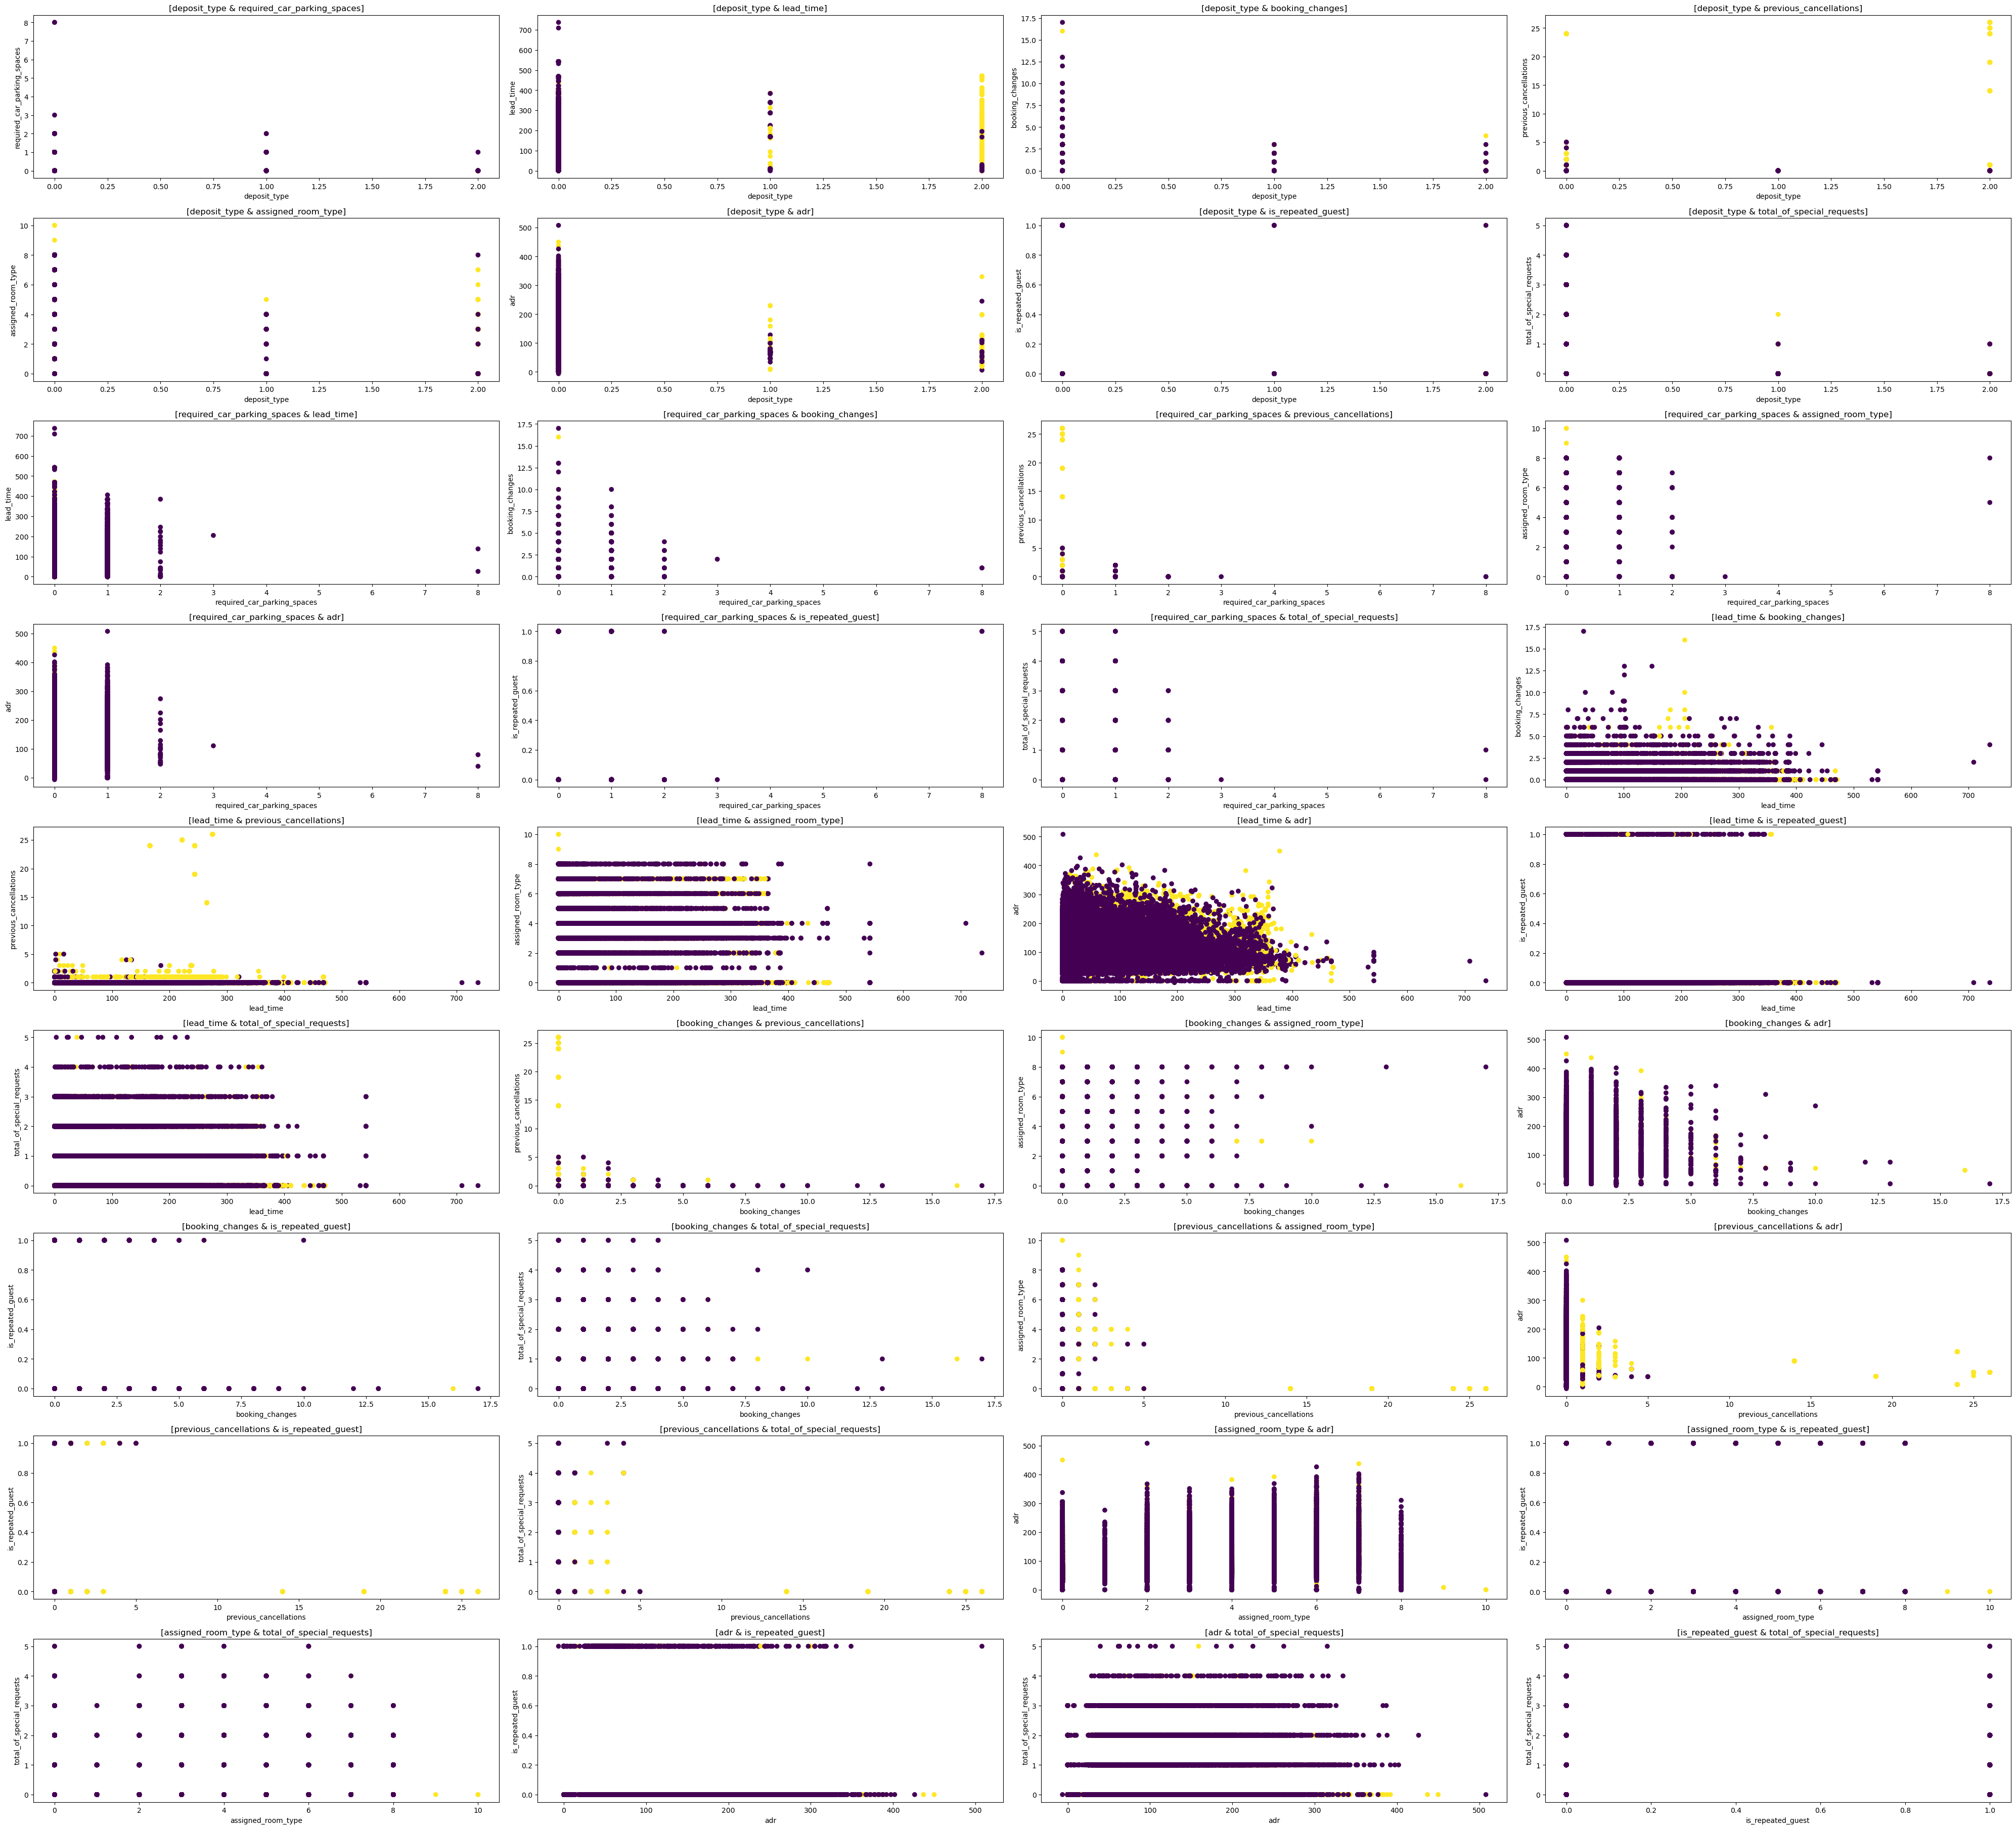

In [120]:
# 피처 - 피처  & 피처 + 타겟 그래프 scatter 그리기
from itertools import combinations

# col = ['deposit_type', 'required_car_parking_spaces', 'lead_time', 'booking_changes', 'previous_cancellations'] 
col= ['deposit_type', 'required_car_parking_spaces', 'lead_time', 'booking_changes', 'previous_cancellations', 'assigned_room_type', 'adr', 'is_repeated_guest', 'total_of_special_requests']
col2= ['is_canceled', 'deposit_type', 'required_car_parking_spaces', 'lead_time', 'booking_changes', 'previous_cancellations', 'assigned_room_type', 'adr', 'is_repeated_guest', 'total_of_special_requests']

# print('가능한 경우의 수 : ', len(list(combinations(col, 2))))col= ['deposit_type', 'required_car_parking_spaces', 'lead_time', 'booking_changes', 'previous_cancellations', 'assigned_room_type', 'adr', 'is_repeated_guest', 'total_of_special_requests']

n = 1
plt.figure(figsize=(40, 80))
for i, v in combinations(col, 2) : 
    #print(i, v) >> 출력값 확인 용도
    plt.subplot(20, 4, n)
    plt.title(f'[{i} & {v}]')
    plt.scatter(rtDF[i], rtDF[v], c = rtDF['is_canceled'])
    plt.xlabel(i)
    plt.ylabel(v)
    n+=1
    if n>len(list(combinations(col2, 2))) :
        break

plt.tight_layout()  # subplot 간의 간격 조정
plt.show()

<Axes: title={'center': '[target & feature corr]'}>

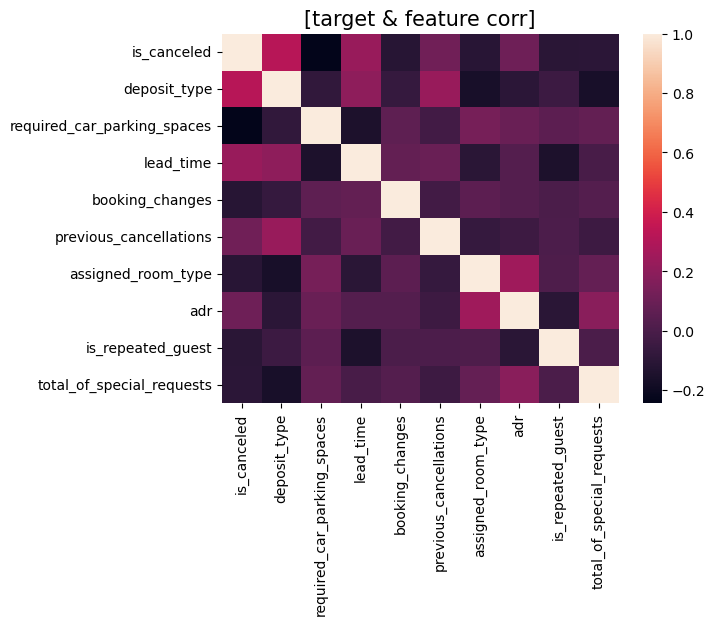

In [121]:
import seaborn as sns
plt.title('[target & feature corr]', fontsize = 15)
sns.heatmap(rtDF[col2].corr(numeric_only=True))

In [122]:
# 피처 - 타겟 분리
featureDF = rtDF[col]
targetSR = rtDF['is_canceled']


# 훈련용 - 테스트 분리.
from sklearn.model_selection import train_test_split

Xtrn, Xtst, ytrn, ytst = train_test_split(featureDF, targetSR, test_size=0.2, stratify=targetSR, random_state = 5)

In [123]:
# 분리한 데이터 확인
print(f'Xtrain = {Xtrn.shape}, Xtest = {Xtst.shape}')
print(f'ytrain = {ytrn.shape}, ytest = {ytst.shape}')

Xtrain = (32048, 9), Xtest = (8012, 9)
ytrain = (32048,), ytest = (8012,)


In [126]:
# 스케일링.

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

stdMdl = StandardScaler()
stdMdl.fit(Xtrn)
stdMdl_Xtrn = stdMdl.transform(Xtrn)
stdMdl_Xtst = stdMdl.transform(Xtst)

mmMdl = MinMaxScaler()
mmMdl.fit(Xtrn)
mmMdl_Xtrn = mmMdl.transform(Xtrn)
mmMdl_Xtst = mmMdl.transform(Xtst)

rbMdl = RobustScaler()
rbMdl.fit(Xtrn)
rbMdl_Xtrn = rbMdl.transform(Xtrn)
rbMdl_Xtst = rbMdl.transform(Xtst)

In [127]:
from sklearn.neighbors import KNeighborsClassifier
trainScore =[]
testScore = []

for k in range(1, 50) :
    kMdl = KNeighborsClassifier(n_neighbors=k)
    kMdl.fit(stdMdl_Xtrn, ytrn)
    kMdl.score(stdMdl_Xtst, ytst)
    trainScore.append(kMdl.score(stdMdl_Xtrn, ytrn))
    testScore.append(kMdl.score(stdMdl_Xtst, ytst))
print(f'Train Score : {trainScore}')
print(f'Test Score : {testScore}')

Train Score : [0.9805292061907139, 0.896280579131303, 0.8873876684972541, 0.8620506739890165, 0.8586183225162256, 0.8476972041937094, 0.8460122316525213, 0.8376809785322017, 0.8364328507239142, 0.8315963554667998, 0.8307226660009985, 0.8286944583125312, 0.8279143784323515, 0.8264166250624064, 0.8251372940589117, 0.8238579630554169, 0.8227034448327508, 0.8211120818771842, 0.8201135796305542, 0.8178981527708438, 0.8174301048427359, 0.8162443834248627, 0.8159323514727909, 0.8143097853220169, 0.8138729405891163, 0.8120007488766849, 0.8123127808287569, 0.8109398402396405, 0.8110646530204693, 0.8100973539690465, 0.8088492261607588, 0.8080067398901648, 0.8087556165751373, 0.8070394408387419, 0.8081939590614079, 0.8069458312531204, 0.8079755366949576, 0.8066650024962556, 0.8076323015476785, 0.8063841737393909, 0.8067586120818772, 0.8056040938592112, 0.8048864203694458, 0.8040439340988518, 0.8039815277084373, 0.8029830254618073, 0.8031390414378432, 0.8035446829755367, 0.8022341487768347]
Test S

In [128]:
from sklearn.neighbors import KNeighborsClassifier
kMdl = KNeighborsClassifier(weights='distance')
kMdl.fit(stdMdl_Xtrn, ytrn)
print(f'Standard Scaler\n[Train] : {kMdl.score(stdMdl_Xtrn, ytrn)}\n[Test score] :{kMdl.score(stdMdl_Xtst, ytst)}')

kMdl.fit(mmMdl_Xtrn, ytrn)
kMdl.score(mmMdl_Xtst, ytst)
print(f'MinMax Scaler\n[Train] : {kMdl.score(mmMdl_Xtrn, ytrn)}\n[Test score] :{kMdl.score(mmMdl_Xtst, ytst)}')

kMdl.fit(rbMdl_Xtrn, ytrn)
kMdl.score(rbMdl_Xtst, ytst)
print(f'Robust Scaler\n[Train] : {kMdl.score(rbMdl_Xtrn, ytrn)}\n[Test score] :{kMdl.score(rbMdl_Xtst, ytst)}')

Standard Scaler
[Train] : 0.9838679480778831
[Test score] :0.8150274588117823
MinMax Scaler
[Train] : 0.9838055416874688
[Test score] :0.8135297054418372
Robust Scaler
[Train] : 0.9838055416874688
[Test score] :0.8156515227159261


In [129]:
trainScore2 =[]
testScore2 =[]

for k in range(1, 50) :
    kMdl = KNeighborsClassifier(n_neighbors=k)
    kMdl.fit(mmMdl_Xtrn, ytrn)
    kMdl.score(mmMdl_Xtst, ytst)
    trainScore2.append(kMdl.score(mmMdl_Xtrn, ytrn))
    testScore2.append(kMdl.score(mmMdl_Xtst, ytst))
print(f'MinMax Train Score : {trainScore2}')
print(f'MinMax Test Score : {testScore2}')

MinMax Train Score : [0.9805292061907139, 0.895126060908637, 0.8864827758362457, 0.8618322516225662, 0.8580878681977034, 0.8470107338991513, 0.8441088367448827, 0.836744882675986, 0.8349975037443834, 0.8292249126310535, 0.8290688966550175, 0.8264166250624064, 0.8253869196205691, 0.8237643534697953, 0.8222978032950574, 0.821236894658013, 0.8198015476784822, 0.8181789815277084, 0.8175237144283575, 0.8161819770344483, 0.8164316025961058, 0.8143721917124314, 0.8137793310034948, 0.8127808287568647, 0.8117511233150274, 0.8104717923115327, 0.809535696455317, 0.808381178232651, 0.8080379430853719, 0.8072578632051922, 0.8067586120818772, 0.8062593609585622, 0.8055416874687968, 0.8052920619071393, 0.805073639540689, 0.8046992011982027, 0.8037943085371942, 0.8028270094857713, 0.802452571143285, 0.8031702446330504, 0.8032326510234647, 0.8020781328007988, 0.8012980529206191, 0.8004555666500249, 0.8012356465302047, 0.8003931602596106, 0.7994570644033949, 0.7994258612081877, 0.7991762356465302]
MinMa

In [130]:
trainScore3 =[]
testScore3 =[]

for k in range(1, 101) :
    kMdl = KNeighborsClassifier(n_neighbors=k)
    kMdl.fit(rbMdl_Xtrn, ytrn)
    kMdl.score(rbMdl_Xtst, ytst)
    trainScore3.append(kMdl.score(rbMdl_Xtrn, ytrn))
    testScore3.append(kMdl.score(rbMdl_Xtst, ytst))
print(f'Robust Train Score : {trainScore3}')
print(f'Robust Test Score : {testScore3}')

Robust Train Score : [0.9804043934098852, 0.8965302046929605, 0.8871380429355966, 0.8620506739890165, 0.8584623065401897, 0.8489765351972042, 0.8466050923614579, 0.8388979031452821, 0.8373377433849226, 0.8335309535696456, 0.8330004992511233, 0.8294745381927109, 0.8279455816275587, 0.8277271592611083, 0.8278519720419371, 0.8256053419870195, 0.8233587119321019, 0.8211432850723914, 0.821080878681977, 0.8196767348976535, 0.8188342486270594, 0.8179605591612581, 0.8167124313529706, 0.815152271592611, 0.816306789815277, 0.8156203195207189, 0.8146218172740889, 0.8125936095856215, 0.8119695456814778, 0.8121879680479281, 0.8111270594108837, 0.8105029955067399, 0.8091924613080379, 0.8077259111333001, 0.808693210184723, 0.8089116325511733, 0.8094420868696954, 0.8084747878182726, 0.8081003494757864, 0.8074138791812282, 0.8074138791812282, 0.8056665002496256, 0.8050112331502746, 0.805073639540689, 0.8057601098352472, 0.8055416874687968, 0.8041375436844733, 0.805073639540689, 0.8055104842735896, 0.80

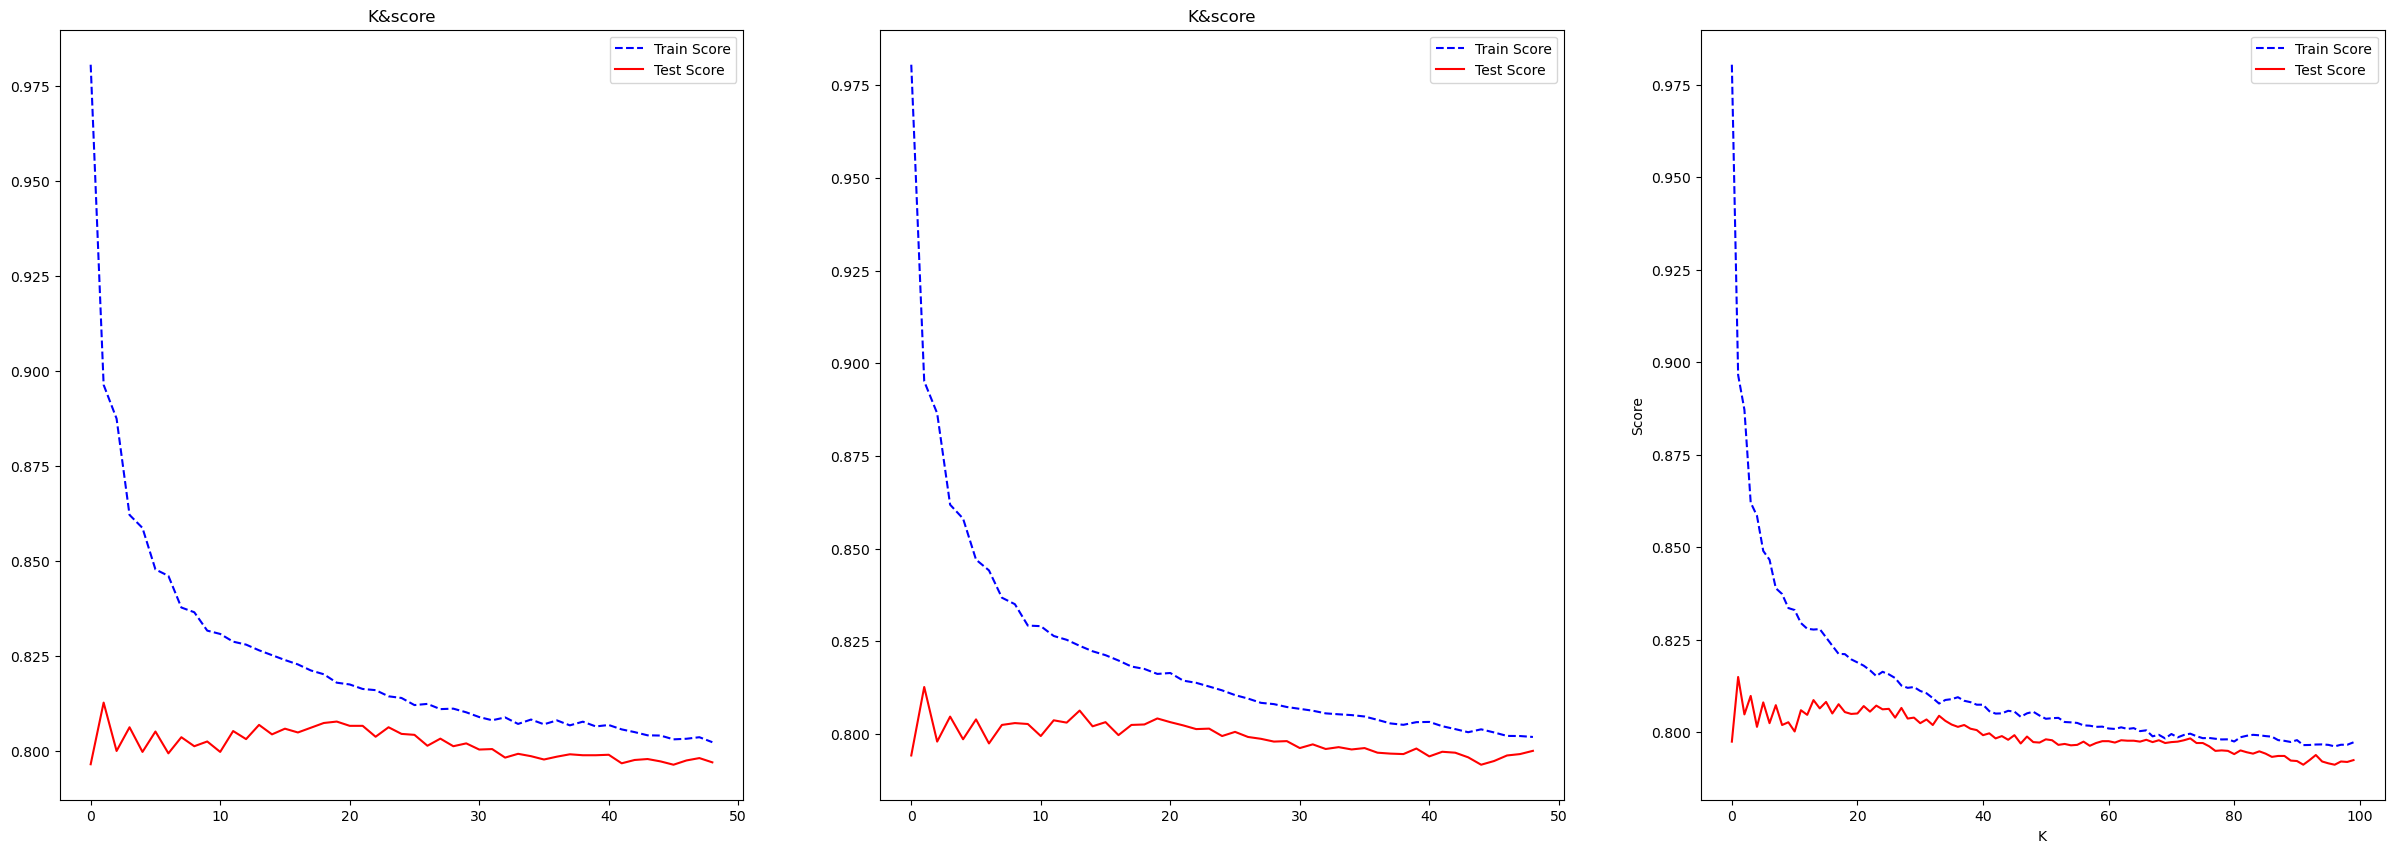

In [131]:
# K개수에 따른 학습용/테스트용 점수 시각화
plt.figure(figsize=(30, 10))
plt.subplot(1,3,1)

plt.title('K&score')
plt.plot(trainScore, 'b--', label = 'Train Score')
plt.plot(testScore, 'r-', label = 'Test Score')
plt.legend()

plt.title('K&score')
plt.subplot(1,3,2)
plt.plot(trainScore2, 'b--', label = 'Train Score')
plt.plot(testScore2, 'r-', label = 'Test Score')
plt.legend()

plt.title('K&score')
plt.subplot(1,3,3)
plt.plot(trainScore3, 'b--', label = 'Train Score')
plt.plot(testScore3, 'r-', label = 'Test Score')
plt.legend()

plt.xlabel('K')
plt.ylabel('Score')
plt.show()

In [132]:
# print(max(testScore))
# print(testScore.index(max(testScore)))
# k = testScore.index(max(testScore))
# k2 = testScore2.index(max(testScore2))
# k3 = testScore3.index(max(testScore3))

# print(k, k2, k3)

In [133]:
kMdl = KNeighborsClassifier(n_neighbors=4, weights='distance')
kMdl.fit(stdMdl_Xtrn, ytrn)
print('train :', kMdl.score(stdMdl_Xtrn, ytrn), 'test :', kMdl.score(stdMdl_Xtst, ytst), sep = '\t')


kMdl = KNeighborsClassifier(n_neighbors=4, weights='distance')
kMdl.fit(mmMdl_Xtrn, ytrn)
print('train :', kMdl.score(mmMdl_Xtrn, ytrn), 'test :', kMdl.score(mmMdl_Xtst, ytst), sep = '\t')

kMdl = KNeighborsClassifier(n_neighbors=4, weights='distance')
kMdl.fit(rbMdl_Xtrn, ytrn)
print('train :', kMdl.score(rbMdl_Xtrn, ytrn), 'test :', kMdl.score(rbMdl_Xtst, ytst), sep = '\t')

train :	0.9837431352970544	test :	0.8142785821268098
train :	0.9837431352970544	test :	0.8116575137294059
train :	0.9837431352970544	test :	0.8155267099350973


In [134]:
# 성능평가
kMdl_yPre = kMdl.predict(stdMdl_Xtst)
kMdl_yPre2 = kMdl.predict(mmMdl_Xtst)
kMdl_yPre3 = kMdl.predict(rbMdl_Xtst)


# 분류
from sklearn.metrics import classification_report

report = classification_report(ytst, kMdl_yPre)
report2 = classification_report(ytst, kMdl_yPre2)
report3 = classification_report(ytst, kMdl_yPre3)

print(report, report2, report3, sep='\n')

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      5788
           1       0.52      0.42      0.46      2224

    accuracy                           0.73      8012
   macro avg       0.65      0.63      0.64      8012
weighted avg       0.71      0.73      0.72      8012

              precision    recall  f1-score   support

           0       0.74      0.73      0.73      5788
           1       0.31      0.32      0.32      2224

    accuracy                           0.62      8012
   macro avg       0.53      0.53      0.53      8012
weighted avg       0.62      0.62      0.62      8012

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      5788
           1       0.68      0.64      0.66      2224

    accuracy                           0.82      8012
   macro avg       0.77      0.76      0.77      8012
weighted avg       0.81      0.82      0.81      8012



In [135]:
from sklearn.linear_model import LogisticRegression

lgMdl = LogisticRegression()
lgMdl.fit(stdMdl_Xtrn, ytrn)
print('std train :', lgMdl.score(stdMdl_Xtrn, ytrn), 'std test :', lgMdl.score(stdMdl_Xtst, ytst), sep = '\t')

lgMdl.fit(mmMdl_Xtrn, ytrn)
print('MinMax train :', lgMdl.score(mmMdl_Xtrn, ytrn), 'MinMax test :', lgMdl.score(mmMdl_Xtst, ytst), sep = '\t')

lgMdl.fit(mmMdl_Xtrn, ytrn)
print('robust train :', lgMdl.score(rbMdl_Xtrn, ytrn), 'robust test :', lgMdl.score(rbMdl_Xtst, ytst), sep = '\t')

std train :	0.7832001997004493	std test :	0.7849475786320519
MinMax train :	0.7770219670494258	MinMax test :	0.7795806290564153
robust train :	0.7309348477284074	robust test :	0.7353969046430354


In [136]:
# 성능평가
lgMdl_yPre = lgMdl.predict(stdMdl_Xtst)
lgMdl_yPre2 = lgMdl.predict(mmMdl_Xtst)
lgMdl_yPre3 = lgMdl.predict(rbMdl_Xtst)


# 분류
from sklearn.metrics import classification_report

lgReport = classification_report(ytst, lgMdl_yPre)
lgReport2 = classification_report(ytst, lgMdl_yPre2)
lgReport3 = classification_report(ytst, lgMdl_yPre3)

print(lgReport, lgReport2, lgReport3, sep='\n')

              precision    recall  f1-score   support

           0       0.93      0.37      0.53      5788
           1       0.36      0.92      0.52      2224

    accuracy                           0.52      8012
   macro avg       0.64      0.64      0.52      8012
weighted avg       0.77      0.52      0.52      8012

              precision    recall  f1-score   support

           0       0.78      0.97      0.86      5788
           1       0.77      0.29      0.42      2224

    accuracy                           0.78      8012
   macro avg       0.78      0.63      0.64      8012
weighted avg       0.78      0.78      0.74      8012

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      5788
           1       0.52      0.59      0.55      2224

    accuracy                           0.74      8012
   macro avg       0.68      0.69      0.68      8012
weighted avg       0.75      0.74      0.74      8012



In [137]:
from sklearn.ensemble import RandomForestClassifier

rfMdl = RandomForestClassifier(random_state=5, oob_score=True) #oob_score=True하면 검증 데이터로 나머지를 쓰겠다!
rfMdl.fit(Xtrn, ytrn)

# DecisionTreeClassifier 인스턴스
from sklearn.tree import DecisionTreeClassifier

dtMdl = DecisionTreeClassifier(criterion='entropy')
dtMdl.fit(Xtrn, ytrn)

print(f'---Standard Scaler---')
print(f'[LogisticRegression] Train : {lgMdl.score(stdMdl_Xtrn, ytrn)}\tTest :{lgMdl.score(stdMdl_Xtst, ytst)}')
print(f'[DecisionTreeClassifier] Train : {dtMdl.score(Xtrn, ytrn)}\tTest :{dtMdl.score(Xtst, ytst)}')
print(f'[RandomForestClassifier] Train : {rfMdl.score(Xtrn, ytrn)}\tTest :{rfMdl.score(Xtst, ytst)}')

print('\n---MinMax Scaler---')
print(f'[LogisticRegression] Train : {lgMdl.score(Xtrn, ytrn)}\tTest :{lgMdl.score(mmMdl_Xtst, ytst)}')
print(f'[DecisionTreeClassifier] Train : {dtMdl.score(Xtrn, ytrn)}\tTest :{dtMdl.score(Xtst, ytst)}')
print(f'[RandomForestClassifier] Train : {rfMdl.score(Xtrn, ytrn)}\tTest :{rfMdl.score(Xtst, ytst)}')

print('\n---Robust Scaler---')
print(f'[LogisticRegression] Train : {lgMdl.score(rbMdl_Xtrn, ytrn)}\tTest :{lgMdl.score(rbMdl_Xtst, ytst)}')
print(f'[DecisionTreeClassifier] Train : {dtMdl.score(Xtrn, ytrn)}\tTest :{dtMdl.score(Xtst, ytst)}')
print(f'[RandomForestClassifier] Train : {rfMdl.score(Xtrn, ytrn)}\tTest :{rfMdl.score(Xtst, ytst)}')


---Standard Scaler---
[LogisticRegression] Train : 0.5272715926110834	Test :0.5212181727408887
[DecisionTreeClassifier] Train : 0.984835247129306	Test :0.803419870194708
[RandomForestClassifier] Train : 0.9847416375436845	Test :0.831627558662007

---MinMax Scaler---
[LogisticRegression] Train : 0.28419870194707936	Test :0.7795806290564153
[DecisionTreeClassifier] Train : 0.984835247129306	Test :0.803419870194708


c:\ProgramData\anaconda3\envs\EXAM_ML\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


[RandomForestClassifier] Train : 0.9847416375436845	Test :0.831627558662007

---Robust Scaler---
[LogisticRegression] Train : 0.7309348477284074	Test :0.7353969046430354
[DecisionTreeClassifier] Train : 0.984835247129306	Test :0.803419870194708
[RandomForestClassifier] Train : 0.9847416375436845	Test :0.831627558662007


In [138]:
# 모듈 로딩
from sklearn.model_selection import GridSearchCV

n_cv = 5
params = {'criterion':['gini', 'entropy', 'log_loss'], 
         'max_depth':[5, 10, 15],
         'min_samples_split':[2, 4, 6]}

# 하이퍼파라미터 조합된 모델 생성 후 교차검증 데이터셋으로 학습 진행해 주는 인스턴스.
gs = GridSearchCV(dtMdl, param_grid=params, cv=n_cv) 

result= gs.fit(Xtrn, ytrn)
result2= gs.fit(Xtrn, ytrn)
result3= gs.fit(Xtrn, ytrn)

# 결과 확인
#result

In [161]:
cv_resultsDF = pd.DataFrame(gs.cv_results_)
#cv_resultsDF

In [140]:
gs.best_params_

my_best_mdl = gs.best_estimator_ 

print(my_best_mdl)
gs.best_score_

DecisionTreeClassifier(criterion='log_loss', max_depth=15, min_samples_split=4)


0.798552352641773

In [141]:
import joblib
import os


# 모델 저장
model_dir = 'miniproject'
model_filename = 'hotel_df.pkl' 
#경로를 지정하지 않으면 현재위치에 저장.

# 저장 폴더 존재 여부 확인 후 저장.
if not os.path.exists('miniproject') :
    os.mkdir('miniproject')

# 모델 파일을 지정된 경로에 저장.
joblib.dump(my_best_mdl, model_filename)

['hotel_df.pkl']

In [143]:
# # from joblib import load

# mdl = load('hotel_df.pkl')


# # 로딩된 모델 확인
# print(mdl.classes_)

# # 사용자로부터 입력 받기
# deposit_type = int(input('보증금 타입을 입력하세요. (no deposite이면 0, Non Refund이면 1, Refundable이면 2): ')) 
# required_car_parking_spaces = int(input('고객이 필요한 주차장 공간 수를 입력하세요. : ')) 

# previous_cancellations = int(input('이전 예약 취소 건수 :'))
# assigned_room_type = int(input('제공된 방 유형 :'))
# adr = int(input('일평균 숙박요금 :' ))

# is_repeated_guest = int(input('이전에 방문한 적 있는 손님이면 1, 아니면 0'))
# total_of_special_requests = int(input('추가요청 사항 :'))
# lead_time = int(input("예약 후 대기 일수를 입력하세요: "))

# arrival_week = int(input("도착 주의 주차를 입력하세요: "))
# booking_changes =  int(input('예약변경/수정 횟수'))

# # 입력된 데이터로 예측
# input_data = [[deposit_type, required_car_parking_spaces, previous_cancellations, 
#                assigned_room_type, adr, is_repeated_guest, total_of_special_requests, 
#                lead_time, arrival_week, booking_changes]]

# prediction = mdl.predict(input_data)


# if prediction == 1:
#     print("예약이 취소될 것으로 예측됩니다.")
# else:
#     print("예약이 유지될 것으로 예측됩니다.")

In [157]:
import joblib
import os

# 필요한 피처 선택
features = rtDF[['deposit_type', 'required_car_parking_spaces', 'lead_time', 'previous_cancellations', 
                 'booking_changes','assigned_room_type', 'adr', 'is_repeated_guest', 'total_of_special_requests']]


# 예측 대상 선택
target = rtDF['is_canceled']

# 데이터 분할
Xtrn, Xtst, ytrn, ytst = train_test_split(features, target, test_size=0.3, random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# 모델 학습
lr = LogisticRegression()
lr.fit(rbMdl_Xtrn, ytrn)



# 모델 저장
joblib.dump(lr, 'hotel_df.pkl')

# 모델 불러오기
loaded_model = joblib.load('hotel_df.pkl')

# 사용자로부터 입력 받기
deposit_type = int(input('보증금 타입을 입력하세요. (no deposite이면 0, Non Refund이면 1, Refundable이면 2): ')) 

required_car_parking_spaces = int(input('고객이 필요한 주차장 공간 수를 입력하세요. : ')) 

previous_cancellations = int(input('이전 예약 취소 건수 :'))
assigned_room_type = int(input('제공된 방 유형을 입력하세요 (예 : 0~10) :'))
adr = int(input('일평균 숙박요금(예 : 60 ) :' ))

is_repeated_guest = int(input('이전에 방문한 적 있는 손님이면 1, 아니면 0을 입력하세요 :'))

total_of_special_requests = int(input('고객의 추가요청 사항 개수를 입력하세요 :'))

lead_time = int(input("예약 후 대기 일수를 입력하세요(0~): "))

booking_changes =  int(input('예약변경/수정 횟수를 입력하세요:'))

# 입력된 데이터로 예측
input_data = [[deposit_type, required_car_parking_spaces, lead_time, previous_cancellations, booking_changes, 
               assigned_room_type, adr, is_repeated_guest, total_of_special_requests]]
prediction = loaded_model.predict(input_data)
pre_proba_cancel = loaded_model.predict_proba(input_data)[0][1]
pre_proba_maintain = loaded_model.predict_proba(input_data)[0][0]

if prediction == 1:
    print(f"{pre_proba_cancel}%의 확률로 예약이 취소될 것으로 예측됩니다.")
else:
    print(f"{pre_proba_maintain}%의 확률로 예약이 유지될 것으로 예측됩니다.")

1.0%의 확률로 예약이 취소될 것으로 예측됩니다.


In [164]:
import joblib
import os

# 필요한 피처 선택
features = rtDF[['deposit_type', 'required_car_parking_spaces', 'lead_time', 'previous_cancellations', 
                 'booking_changes','assigned_room_type', 'adr', 'is_repeated_guest', 'total_of_special_requests']]


# 예측 대상 선택
target = rtDF['is_canceled']

# 데이터 분할
Xtrn, Xtst, ytrn, ytst = train_test_split(features, target, test_size=0.3, random_state=42)


from sklearn.tree import DecisionTreeClassifier

# 모델 학습
dc = DecisionTreeClassifier()
dc.fit(Xtrn, ytrn)



# 모델 저장
joblib.dump(lr, 'hotel_df.pkl')

# 모델 불러오기
loaded_model = joblib.load('hotel_df.pkl')

# 사용자로부터 입력 받기
deposit_type = int(input('보증금 타입을 입력하세요. (no deposite이면 0, Non Refund이면 1, Refundable이면 2): ')) 

required_car_parking_spaces = int(input('고객이 필요한 주차장 공간 수를 입력하세요. : ')) 

previous_cancellations = int(input('이전 예약 취소 건수 :'))
assigned_room_type = int(input('제공된 방 유형을 입력하세요 (예 : 0~10) :'))
adr = int(input('일평균 숙박요금(예 : 60 ) :' ))

is_repeated_guest = int(input('이전에 방문한 적 있는 손님이면 1, 아니면 0을 입력하세요 :'))

total_of_special_requests = int(input('고객의 추가요청 사항 개수를 입력하세요 :'))

lead_time = int(input("예약 후 대기 일수를 입력하세요(0~): "))

booking_changes =  int(input('예약변경/수정 횟수를 입력하세요:'))

# 입력된 데이터로 예측
input_data = [[deposit_type, required_car_parking_spaces, lead_time, previous_cancellations, booking_changes, assigned_room_type, adr, 
               is_repeated_guest, total_of_special_requests]]

prediction = loaded_model.predict(input_data)
pre_proba_cancel = loaded_model.predict_proba(input_data)[0][1]
pre_proba_maintain = loaded_model.predict_proba(input_data)[0][0]

if prediction == 1:
    print(f"{pre_proba_cancel}%의 확률로 예약이 취소될 것으로 예측됩니다.")
else:
    print(f"{pre_proba_maintain}%의 확률로 예약이 유지될 것으로 예측됩니다.")

1.0%의 확률로 예약이 취소될 것으로 예측됩니다.
